In [4]:
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
import json

In [5]:
from keras.layers.core import Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from keras.layers import Lambda
from keras.layers import GaussianNoise
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [6]:
def the_model():
    model = Sequential()
    ch, row, col = 3, 30, 160
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch)))
    model.add(Convolution2D(16, 3, 3, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ELU())
    
    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(ELU())
    
    model.add(Flatten())
    
    model.add(Dense(800, name='Dense1'))
    model.add(ELU())
    
    model.add(Dense(600, name='Dense2'))
    model.add(ELU())
    
    model.add(Dense(300, name='Dense3'))
    model.add(ELU())
    
    model.add(Dense(100, name='Dense4'))
    model.add(ELU())
    
    model.add(Dense(10, name='Dense5'))
    model.add(ELU())
    model.add(Dropout(0.2))
    
    model.add(Dense(1, name='out'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-08)
    model.compile(optimizer=adam, loss="mse")
    return model

In [7]:
def save_parameters(model):
    model.save_weights('model.h5')
    json_file = open('model.json', mode='w')
    json.dump(model.to_json(), json_file)

In [8]:
log = pd.read_csv('./data/driving_log.csv')
print(log['center'].shape)

# X_train_paths = pd.concat([log['center'], log['right'], log['left']])
X_train_paths = log['center']
# y_train = pd.concat([log['steering'], log['steering'] - 0.25, log['steering']  + 0.25])
                 
y_train = log['steering']

(8036,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_paths, y_train, test_size=0.1)

In [10]:
def generator(X, Y):
    while 1:
        for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.asarray(np.reshape(angle, [1]), dtype=np.float64)
            datapath = './data/' + path
            datapath = datapath.replace(" ", "")
            image = Image.open(datapath).convert('RGB')
            image.resize((32, 16))
            image = np.asarray(image, dtype=np.float64)
            image = image[None, :, :, :]
            yield image, angle

In [11]:
import cv2
import matplotlib.pyplot as plt
def data_collector(X, Y):
    images = []
    angles = []
    i = 0
    for (x, y) in zip(X, Y):
        path, angle = (x, y)
        angle = np.asarray(np.reshape(angle, [1]), dtype=np.float64)
        datapath = './data/' + path
        datapath = datapath.replace(" ", "")
        image = cv2.imread(datapath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image.shape)
        image = cv2.resize(image, (0, 0), fx=1/2, fy = 1/2)
        image = image[26:56, 0:160]
        print(image.shape)
        images.append(image)
        angles.append(angle)
        print(i)
        i += 1
    return images, angles

In [12]:
X_train, y_train = data_collector(X_train, y_train)
X_valid, y_valid = data_collector(X_valid, y_valid)

(160, 320, 3)
(30, 160, 3)
0
(160, 320, 3)
(30, 160, 3)
1
(160, 320, 3)
(30, 160, 3)
2
(160, 320, 3)
(30, 160, 3)
3
(160, 320, 3)
(30, 160, 3)
4
(160, 320, 3)
(30, 160, 3)
5
(160, 320, 3)
(30, 160, 3)
6
(160, 320, 3)
(30, 160, 3)
7
(160, 320, 3)
(30, 160, 3)
8
(160, 320, 3)
(30, 160, 3)
9
(160, 320, 3)
(30, 160, 3)
10
(160, 320, 3)
(30, 160, 3)
11
(160, 320, 3)
(30, 160, 3)
12
(160, 320, 3)
(30, 160, 3)
13
(160, 320, 3)
(30, 160, 3)
14
(160, 320, 3)
(30, 160, 3)
15
(160, 320, 3)
(30, 160, 3)
16
(160, 320, 3)
(30, 160, 3)
17
(160, 320, 3)
(30, 160, 3)
18
(160, 320, 3)
(30, 160, 3)
19
(160, 320, 3)
(30, 160, 3)
20
(160, 320, 3)
(30, 160, 3)
21
(160, 320, 3)
(30, 160, 3)
22
(160, 320, 3)
(30, 160, 3)
23
(160, 320, 3)
(30, 160, 3)
24
(160, 320, 3)
(30, 160, 3)
25
(160, 320, 3)
(30, 160, 3)
26
(160, 320, 3)
(30, 160, 3)
27
(160, 320, 3)
(30, 160, 3)
28
(160, 320, 3)
(30, 160, 3)
29
(160, 320, 3)
(30, 160, 3)
30
(160, 320, 3)
(30, 160, 3)
31
(160, 320, 3)
(30, 160, 3)
32
(160, 320, 3)
(30, 1

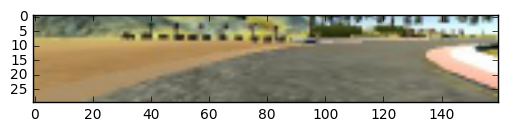

In [13]:
plt.imshow(X_train[100])
plt.show()
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [14]:
batches = 100
epochs = 200

In [15]:
model = the_model()
model.fit(X_train, y_train, batch_size=batches, nb_epoch=epochs, verbose=1, validation_data=(X_valid, y_valid))

Train on 7232 samples, validate on 804 samples
Epoch 1/200
7232/7232 [==============================] - 8s - loss: 0.0171 - val_loss: 0.0127
Epoch 2/200
7232/7232 [==============================] - 6s - loss: 0.0103 - val_loss: 0.0120
Epoch 3/200
7232/7232 [==============================] - 6s - loss: 0.0096 - val_loss: 0.0116
Epoch 4/200
7232/7232 [==============================] - 6s - loss: 0.0092 - val_loss: 0.0108
Epoch 5/200
7232/7232 [==============================] - 6s - loss: 0.0089 - val_loss: 0.0108
Epoch 6/200
7232/7232 [==============================] - 6s - loss: 0.0085 - val_loss: 0.0111
Epoch 7/200
7232/7232 [==============================] - 6s - loss: 0.0082 - val_loss: 0.0110
Epoch 8/200
7232/7232 [==============================] - 6s - loss: 0.0082 - val_loss: 0.0102
Epoch 9/200
7232/7232 [==============================] - 6s - loss: 0.0079 - val_loss: 0.0102
Epoch 10/200
7232/7232 [==============================] - 6s - loss: 0.0077 - val_loss: 0.0108
Epoch 11/200

In [16]:
#model = the_model()
#model.fit_generator(generator(X_train, y_train), 
#                    samples_per_epoch= X_train.shape[0],
#                    nb_epoch=epochs,
#                    verbose=1,
#                    validation_data=generator(X_valid, y_valid),
#                   nb_val_samples=X_valid.shape[0])

In [17]:
save_parameters(model)